In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


与LSTM.inynb的区别就是这里不再划分训练集和测试集合，所有的数据都是训练集

In [ ]:
with open("/content/drive/MyDrive/covid/data/data_table_for_daily_case_trends__the_united_states.csv", "r", encoding="utf-8") as f:
    data = f.read()

data = [row.split(',') for row in  data.split("\n")]

# value = [int(each[1]) for each in data]
value = [float(each[2]) for each in data[1:]]


seq = 7

# 训练集构造

li_x = []
li_y = []

for i in range(len(value) - seq):
    # 输入就是[x, x+1, x+2, ... , x + (seq-1)]天的数据，输出是 x + seq 天的数据
    li_x.append(value[i: i+seq])
    li_y.append(value[i+seq])



train_x = (torch.tensor(li_x).float() / 1000.).reshape(-1, seq, 1).to(device)
train_y = (torch.tensor(li_y).float() / 1000.).reshape(-1, 1).to(device)




In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        # 输入格式是1，输出隐藏层大小是32
        # 对于小数据集num_layers不要设置大，否则会因为模型变复杂而导致效果会变差
        # num_layers顾名思义就是有几个lstm层，假如设置成2，就相当于连续经过两个lstm层
        # 原来的输入格式是：(seq, batch, shape)
        # 设置batch_first=True以后，输入格式就可以改为：(batch, seq, shape)，更符合平常使用的习惯
        self.linear = nn.Linear(32*seq, 1)

    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = x.reshape(-1, 32*seq)
        x = self.linear(x)
        return x

In [ ]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

In [ ]:
model.train()
for epoch in range(3000):
    output = model(train_x)
    loss = loss_fun(output, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0 and epoch > 0:
        print("epoch:{}, loss:{}".format(epoch, loss))


epoch:20, loss:1773.0020751953125
epoch:40, loss:1761.140869140625
epoch:60, loss:1749.986083984375
epoch:80, loss:1738.9833984375
epoch:100, loss:1728.1094970703125
epoch:120, loss:1717.327880859375
epoch:140, loss:1710.18505859375
epoch:160, loss:1700.786376953125
epoch:180, loss:1688.8863525390625
epoch:200, loss:1677.3690185546875
epoch:220, loss:1669.5806884765625
epoch:240, loss:1658.644775390625
epoch:260, loss:1649.0135498046875
epoch:280, loss:1639.705322265625
epoch:300, loss:1627.2230224609375
epoch:320, loss:1618.3812255859375
epoch:340, loss:1611.79638671875
epoch:360, loss:1600.8402099609375
epoch:380, loss:1594.300537109375
epoch:400, loss:1580.3397216796875
epoch:420, loss:1575.2978515625
epoch:440, loss:1564.885986328125
epoch:460, loss:1552.5665283203125
epoch:480, loss:1545.4656982421875
epoch:500, loss:1535.52099609375
epoch:520, loss:1525.045166015625
epoch:540, loss:1516.2183837890625
epoch:560, loss:1507.9290771484375
epoch:580, loss:1501.7457275390625
epoch:600,

绘制训练效果图

MSE: 394198660.0


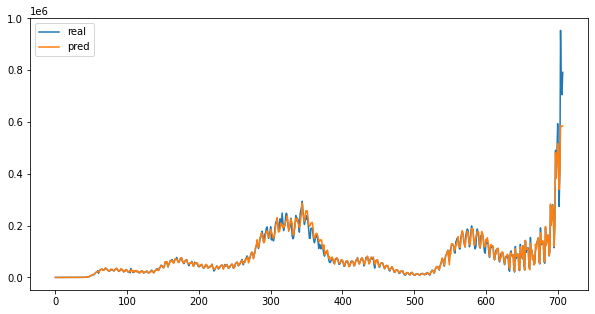

In [ ]:
model.eval()

train_pre = list((model(train_x).data.reshape(-1))*1000)

from sklearn.metrics import mean_squared_error
print("MSE:", mean_squared_error(train_y*1000, train_pre))


plt.figure(figsize=(10,5))

# 真实数据
plt.plot(train_y*1000, label="real")


# 预测结果
plt.plot(train_pre, label="pred")

# 模型预测的走势
plt.legend(loc='best')

In [ ]:
result = []

# 使用训练集最后七天的数据作为起始点

result.append(train_x[707][0][0])
result.append(train_x[707][1][0])
result.append(train_x[707][2][0])
result.append(train_x[707][3][0])
result.append(train_x[707][4][0])
result.append(train_x[707][5][0])
result.append(train_x[707][6][0])


print(result)

[tensor(593.7250), tensor(453.6930), tensor(273.9400), tensor(404.6440), tensor(954.0090), tensor(718.4990), tensor(705.3510)]


37
37


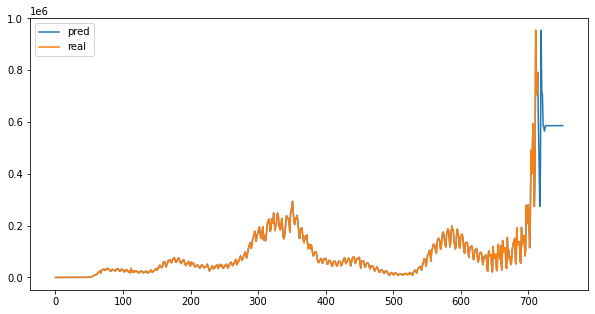

In [ ]:
# 预测未来30天的数据，
for i in range(30):
  result.append(model(torch.tensor(result[i:i+7]).reshape(1,7,1)))

print(len(result)) 



results =  value + [i * 1000 for i in result]
print(len(result))



plt.figure(figsize=(10,5))

# 预测结果
plt.plot(results, label="pred")

# 真实数据
plt.plot(value, label="real")


# 模型预测的走势
plt.legend(loc='best')